In [89]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors

import copy
import datetime
import numpy as np
from math import sqrt
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from scipy.special import inv_boxcox
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")

In [90]:
df = pd.read_csv('./Electric_Production.csv')
date_column = 'DATE'
data_column = 'IPG2211A2N'

df.dropna(inplace=True)
df[data_column] = df[data_column].astype(float)
df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y')
df = df.set_index([date_column])
df.sort_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


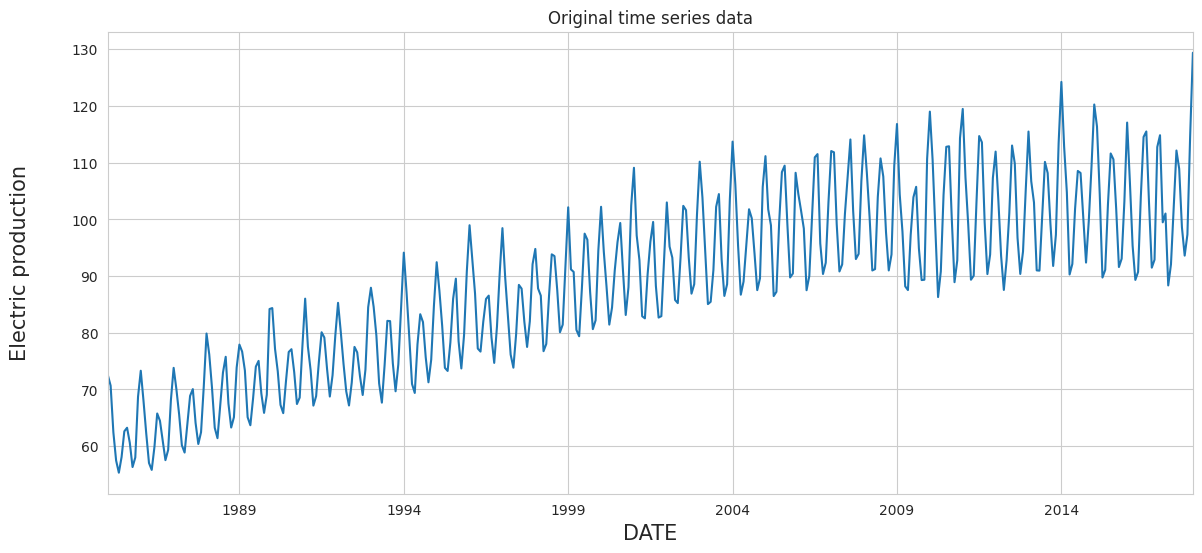

In [91]:
plt.figure(figsize=(14, 6))
plt.title('Original time series data')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Electric production', rotation=90, labelpad=30, fontsize=15)
df[data_column].plot();

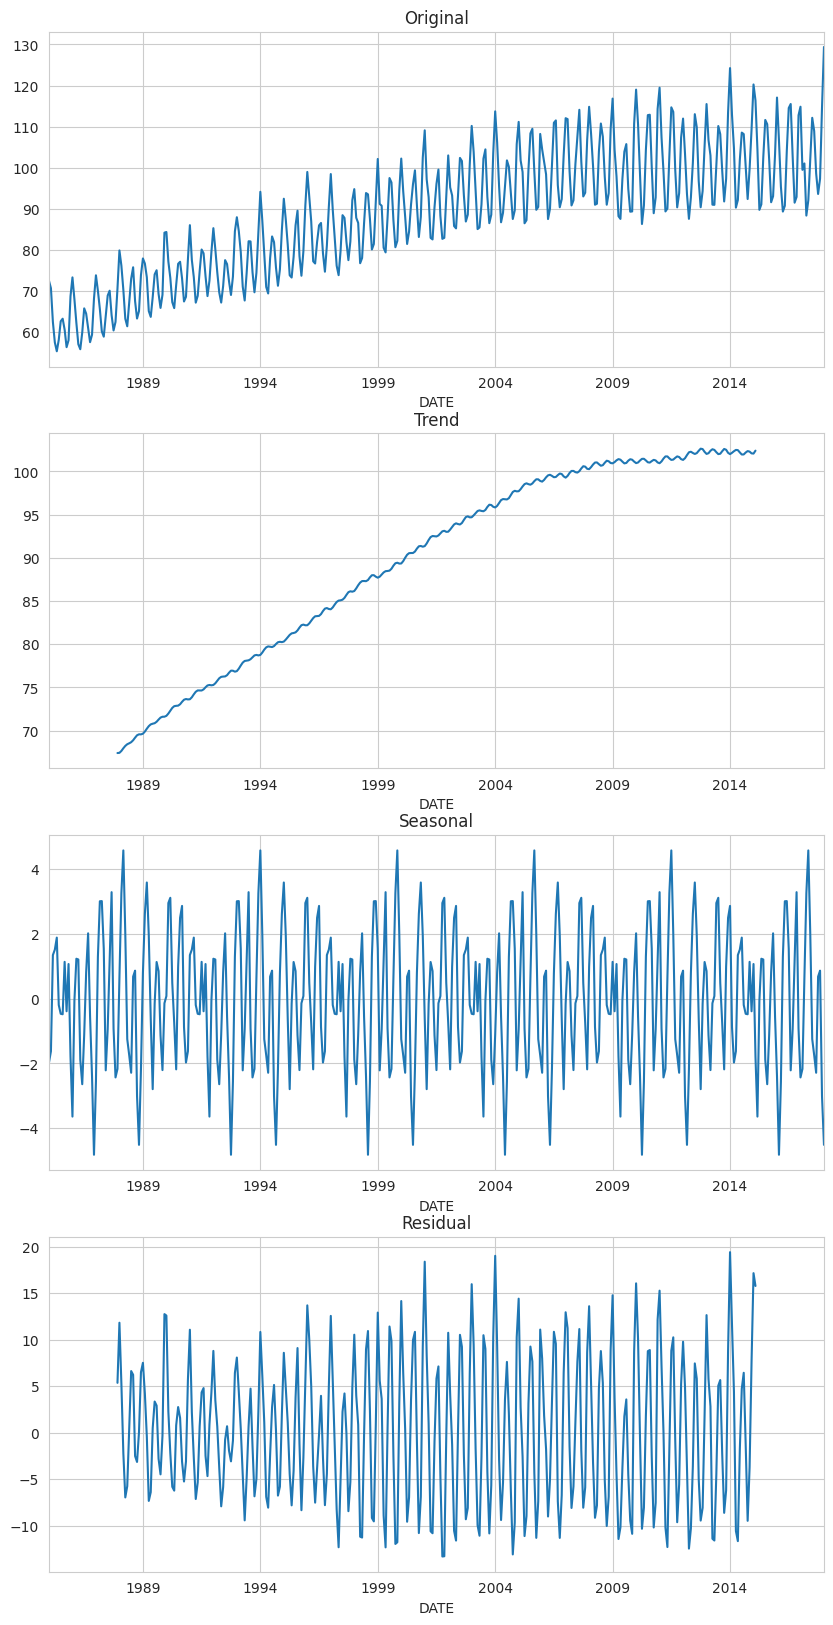

In [92]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
decompose = seasonal_decompose(df[[data_column]], period=70)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

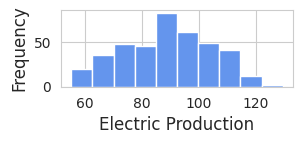

In [93]:
plt.figure(figsize = (3,1))
plt.hist(df[data_column], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

<Figure size 500x300 with 0 Axes>

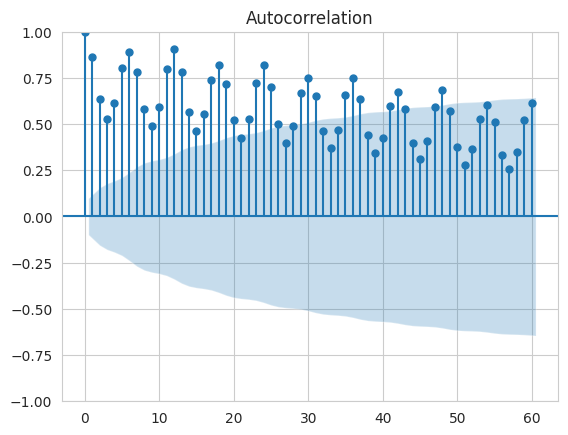

In [94]:
plt.figure(figsize=(5, 3))
plot_acf(df[data_column], lags=60);

In [95]:
def adfuller_test(ts):

    adf = adfuller(ts, autolag='AIC')

    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")
    print('Critical Values:')

    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")

    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")

adfuller_test(df)


ADF Statistic: -2.257
p-value: 0.186
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF > Critical Values
Failed to reject null hypothesis, time series is non-stationary.


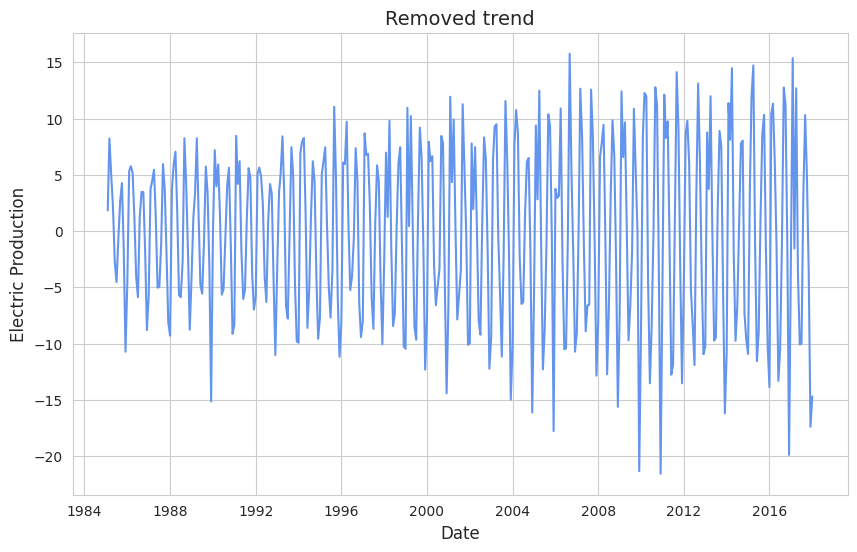

In [96]:
df[data_column] = df[data_column].shift(1) - df[data_column]
df.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("Removed trend", size = 14)
plt.show()

In [97]:
adfuller_test(df)

ADF Statistic: -7.105
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


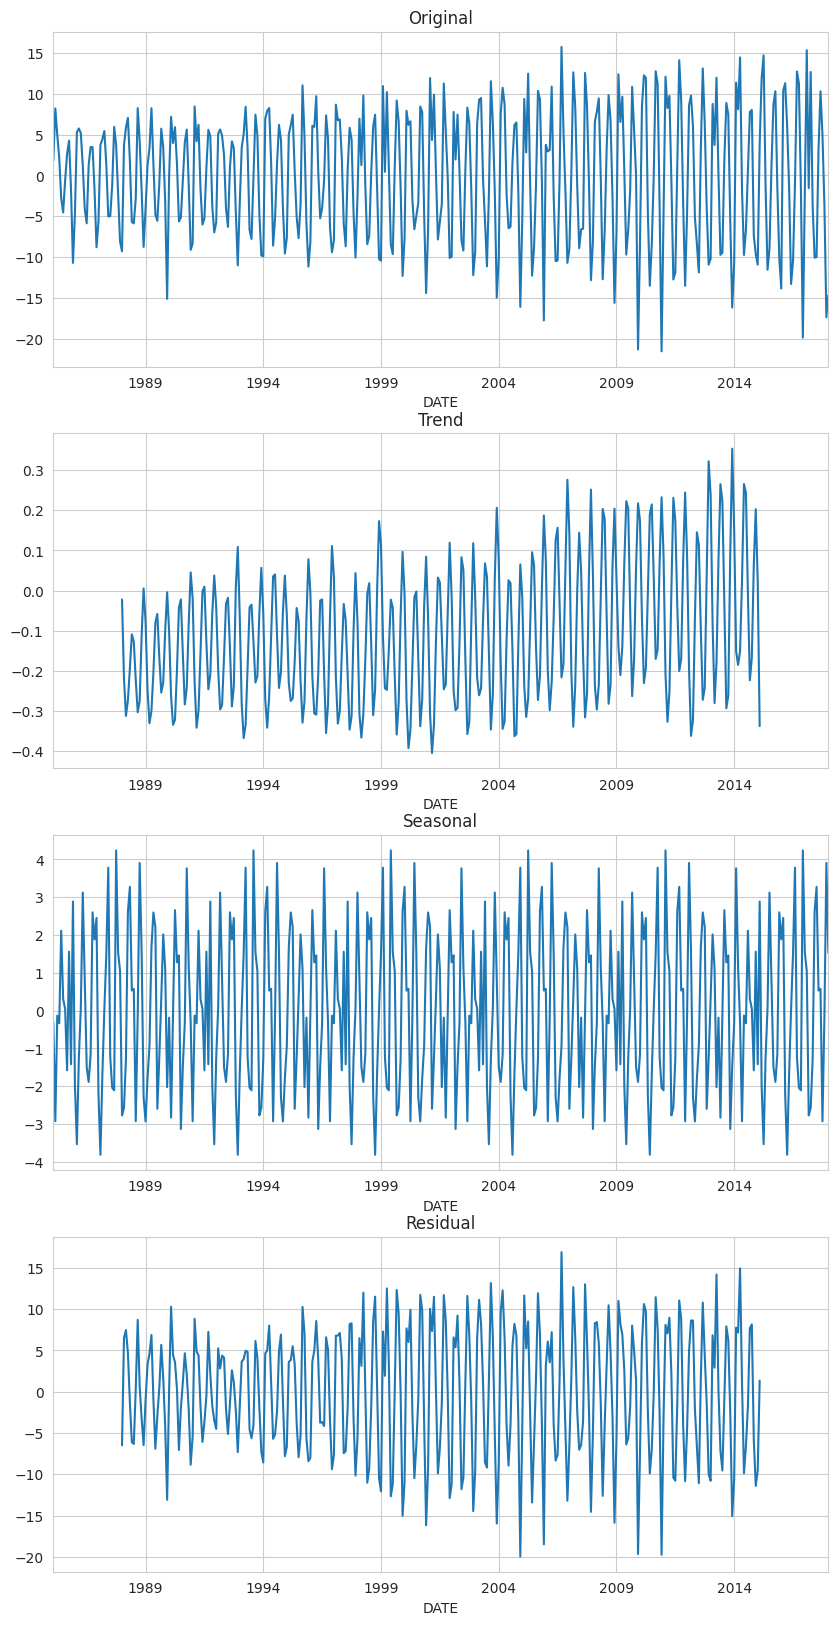

In [98]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))
decompose = seasonal_decompose(df[[data_column]], period=70)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

<Figure size 500x300 with 0 Axes>

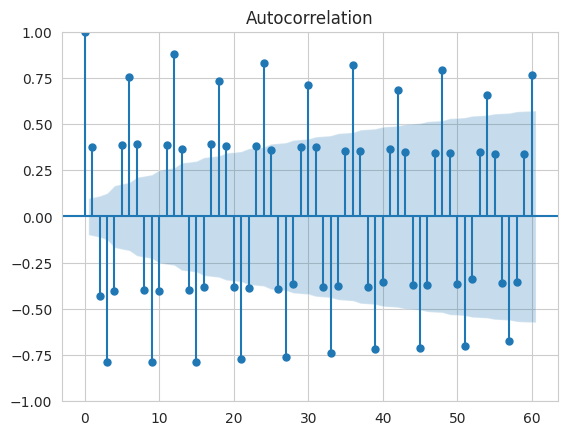

In [99]:
plt.figure(figsize=(5, 3))
plot_acf(df[data_column], lags=60);

In [100]:
ar_values = df.values
ar_indexes = df.index


train_len = int(len(ar_values) * 0.8)
predict_len = len(ar_values) - train_len

train_indexes = ar_indexes[:train_len]
train = ar_values[:train_len]

test_indexes = ar_indexes[train_len:]
test = ar_values[train_len:]

In [ ]:
limit = 7
aic_res = []
for p in range(limit):
  for d in range(limit):
    for q in range(limit):
      model = ARIMA(train, order=(p, d, q))
      try:
        ARIMA_model = model.fit()
        cur_aic = ARIMA_model.aic
        aic_res.append([cur_aic, [p, d, q]])
      except np.linalg.LinAlgError:
        print(p, d, q, 'order error')
aic_res.sort()

In [103]:
for i in range(10):
  print(aic_res[i])

[1585.555761380544, [5, 0, 6]]
[1590.8528142892465, [6, 0, 5]]
[1596.2644876892266, [4, 0, 6]]
[1600.4648399364003, [5, 0, 5]]
[1601.0077631253362, [6, 0, 6]]
[1604.7374920397033, [2, 0, 4]]
[1607.3464419040074, [2, 1, 5]]
[1608.7993404666001, [2, 0, 6]]
[1609.5653015803425, [3, 0, 6]]
[1609.6507719247008, [3, 1, 6]]


In [43]:
# не смотря на лучший показатель с параметрами p = 5 d = 0 q = 5, При восстановлении тренда получается большое расхождение
# опытным путем было замечено, что при d = 1 итоговый результат значительно лучше

In [ ]:
model = ARIMA(train, order=(5, 1, 5))
ARIMA_model = model.fit()
aic_metric = ARIMA_model.aic

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

In [115]:
print(aic_metric)

1649.7451931823525


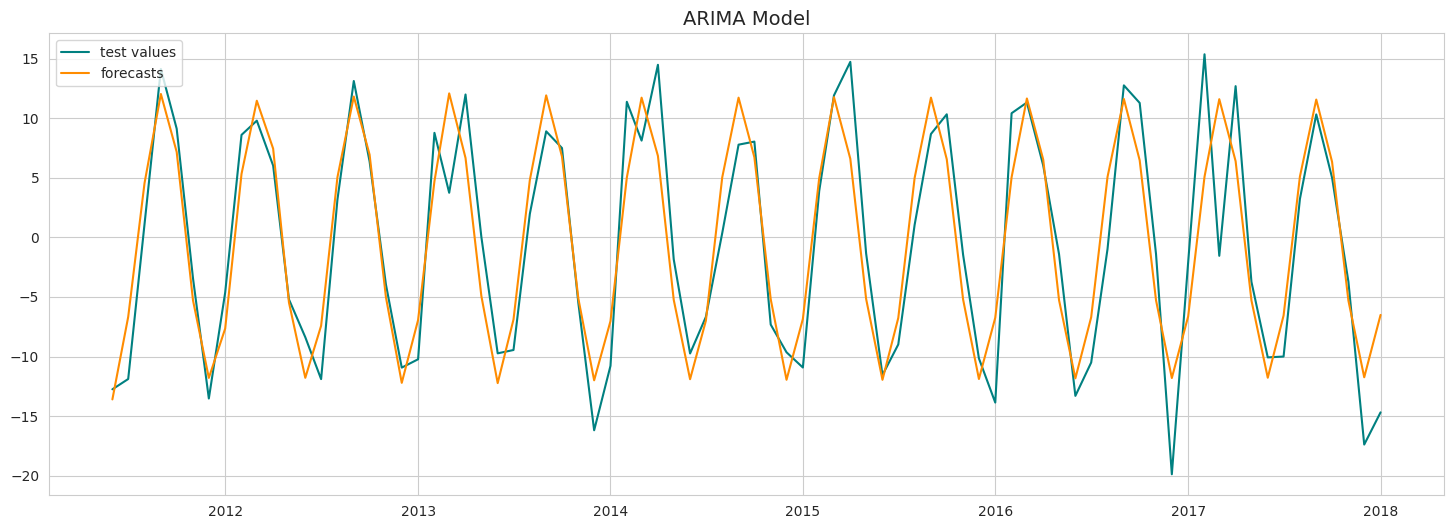

2018-01-01 00:00:00


In [116]:
plt.figure(figsize = (18,6))
plt.plot(test_indexes, test, label = "test values", color = "teal")
plt.plot(test_indexes, predictions, label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()
print(test_indexes[-1])

In [117]:
df = pd.read_csv('./Electric_Production.csv')
date_column = 'DATE'
data_column = 'IPG2211A2N'

df.dropna(inplace=True)
df[data_column] = df[data_column].astype(float)
df[date_column] = pd.to_datetime(df[date_column], format='%m/%d/%Y')
df = df.set_index([date_column])
df.sort_index(inplace=True)

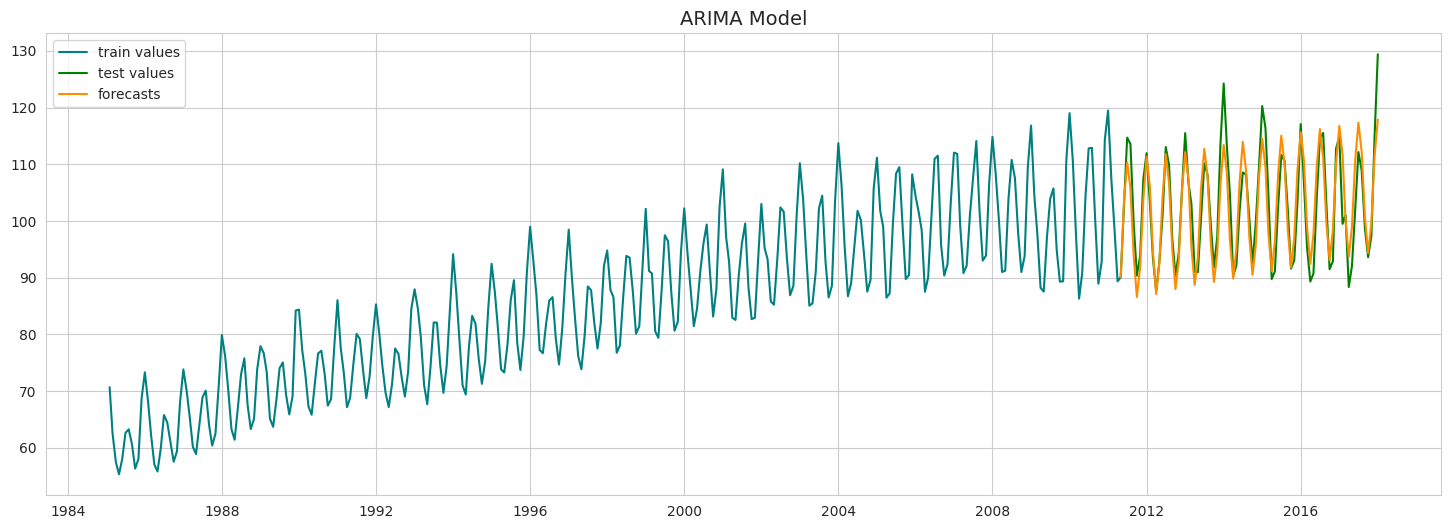

In [118]:
trend_train = df[data_column][1:train_len + 1]
trend_test = df[data_column].values[train_len:]

trend_train_ind = df.index[1:train_len + 1]
trend_test_ind = df.index[train_len:]

trend_predict = []
trend_predict.append(trend_test[0])
for i in range(len(predictions)):
  trend_predict.append(trend_predict[-1] - predictions[i])

plt.figure(figsize = (18,6))
plt.plot(trend_train_ind, trend_train, label = "train values", color = "teal")
plt.plot(trend_test_ind, trend_test, label = "test values", color='green')
plt.plot(trend_test_ind, trend_predict, label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

In [119]:
def mape( actual , pred ):
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

mse = mean_absolute_percentage_error(trend_test, trend_predict)
print(f'mse = {mse}')
print(f'mape = {mape(trend_test, trend_predict)}')

# my ARIMA model metrics
# mse = 0.08372900488893635
# mape = 8.372900488893634

mse = 0.034783374936089045
mape = 3.4783374936089047
